This is mostly just experimentation - probably should remove from final repo.

In [1]:
import sys

# others will need to change the below line to point at broadbandequity directory
# this is necessary so that the jupyternotebook can load our package
sys.path[0] = '/Users/drewkeller/Desktop/CS/broadbandequity'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from data_pipeline.fetch_census_data import acs5_aggregate 
from data_pipeline import spatial_operations as so
from data_pipeline import interactive_mapping as im
import numpy as np
import pandas as pd
from IPython.display import display
import geopandas as gpd
import os


In [3]:
tract_data = acs5_aggregate()[["estimated total population","tract"]]
tract_data['population'] = tract_data['estimated total population']
tract_data = tract_data.drop(columns='estimated total population')
tract_data.head()

,tract,population
0,630200,1825
1,580700,5908
2,590600,3419
3,600700,2835
4,611900,1639


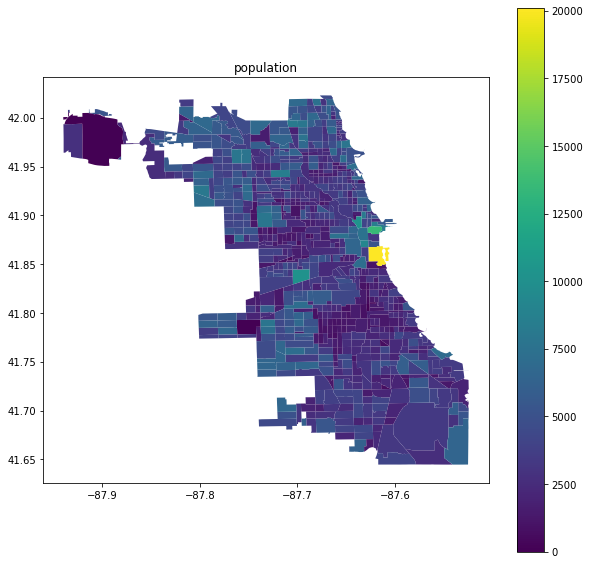

In [4]:
plt.rcParams['figure.figsize'] = [10, 10]  # add more space
so.simple_map(tract_data,'population','tract')

Nice. That's a correct map of Chicago tracts (note the clear lakeshore boundary) and correct 2019 population.

Now we want to rewrite the shapefile to have the right columns.

In [8]:
tract_shapefile = '/Users/drewkeller/Desktop/CS/broadbandequity/geo/tracts.shp'

In [5]:
geo = gpd.read_file(tract_shapefile)
geo

/Users/drewkeller/opt/anaconda3/envs/broadbandequity/lib/python3.8/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community_,geometry
0,37281.254752,6.177154e+07,0.000000,60840000,840000,60,"MULTIPOLYGON (((1096672.940 1927611.312, 10966..."
1,6102.900390,1.777035e+06,0.000000,76840801,840801,76,"MULTIPOLYGON (((1096672.956 1927611.220, 10966..."
2,16035.054991,8.947394e+06,0.320945,59840300,840300,59,"POLYGON ((1163591.927 1881471.238, 1163525.437..."
3,14719.012184,8.946045e+06,0.320896,60840200,840200,60,"POLYGON ((1172724.229 1887341.263, 1172726.397..."
4,15186.400644,1.230614e+07,0.441424,34841100,841100,34,"POLYGON ((1176041.550 1889791.988, 1176043.375..."
...,...,...,...,...,...,...,...
804,13232.831455,1.060785e+07,0.380506,63630300,630300,63,"POLYGON ((1155907.427 1870638.274, 1155911.403..."
805,10648.157958,7.085428e+06,0.254156,63630400,630400,63,"POLYGON ((1158644.638 1868060.212, 1158578.114..."
806,10637.040410,7.079999e+06,0.253961,63630500,630500,63,"POLYGON ((1161234.867 1870796.334, 1161237.841..."
807,10625.328587,7.059211e+06,0.253215,63630800,630800,63,"POLYGON ((1158719.744 1865406.385, 1158653.489..."


In [6]:
# remove unneeded columns
geo = geo[[
    'Shape_Leng','Shape_Area','SqMiles','GEOID2','tract','community_','geometry'
    ]]

In [7]:
# rename columns
geo = geo.rename(columns={
    "tract" : "tract",
    "community_" : "community"
})
geo

,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community,geometry
0,37281.254752,6.177154e+07,0.000000,60840000,840000,60,"MULTIPOLYGON (((1096672.940 1927611.312, 10966..."
1,6102.900390,1.777035e+06,0.000000,76840801,840801,76,"MULTIPOLYGON (((1096672.956 1927611.220, 10966..."
2,16035.054991,8.947394e+06,0.320945,59840300,840300,59,"POLYGON ((1163591.927 1881471.238, 1163525.437..."
3,14719.012184,8.946045e+06,0.320896,60840200,840200,60,"POLYGON ((1172724.229 1887341.263, 1172726.397..."
4,15186.400644,1.230614e+07,0.441424,34841100,841100,34,"POLYGON ((1176041.550 1889791.988, 1176043.375..."
...,...,...,...,...,...,...,...
804,13232.831455,1.060785e+07,0.380506,63630300,630300,63,"POLYGON ((1155907.427 1870638.274, 1155911.403..."
805,10648.157958,7.085428e+06,0.254156,63630400,630400,63,"POLYGON ((1158644.638 1868060.212, 1158578.114..."
806,10637.040410,7.079999e+06,0.253961,63630500,630500,63,"POLYGON ((1161234.867 1870796.334, 1161237.841..."
807,10625.328587,7.059211e+06,0.253215,63630800,630800,63,"POLYGON ((1158719.744 1865406.385, 1158653.489..."


In [9]:
# write to shapefile
geo.to_file(tract_shapefile)

In [10]:
# reload to check
geo = gpd.read_file(tract_shapefile)
geo

/Users/drewkeller/opt/anaconda3/envs/broadbandequity/lib/python3.8/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community,geometry
0,37281.254752,6.177154e+07,0.000000,60840000,840000,60,"MULTIPOLYGON (((1096672.940 1927611.312, 10966..."
1,6102.900390,1.777035e+06,0.000000,76840801,840801,76,"MULTIPOLYGON (((1096672.956 1927611.220, 10966..."
2,16035.054991,8.947394e+06,0.320945,59840300,840300,59,"POLYGON ((1163591.927 1881471.238, 1163525.437..."
3,14719.012184,8.946045e+06,0.320896,60840200,840200,60,"POLYGON ((1172724.229 1887341.263, 1172726.397..."
4,15186.400644,1.230614e+07,0.441424,34841100,841100,34,"POLYGON ((1176041.550 1889791.988, 1176043.375..."
...,...,...,...,...,...,...,...
804,13232.831455,1.060785e+07,0.380506,63630300,630300,63,"POLYGON ((1155907.427 1870638.274, 1155911.403..."
805,10648.157958,7.085428e+06,0.254156,63630400,630400,63,"POLYGON ((1158644.638 1868060.212, 1158578.114..."
806,10637.040410,7.079999e+06,0.253961,63630500,630500,63,"POLYGON ((1161234.867 1870796.334, 1161237.841..."
807,10625.328587,7.059211e+06,0.253215,63630800,630800,63,"POLYGON ((1158719.744 1865406.385, 1158653.489..."


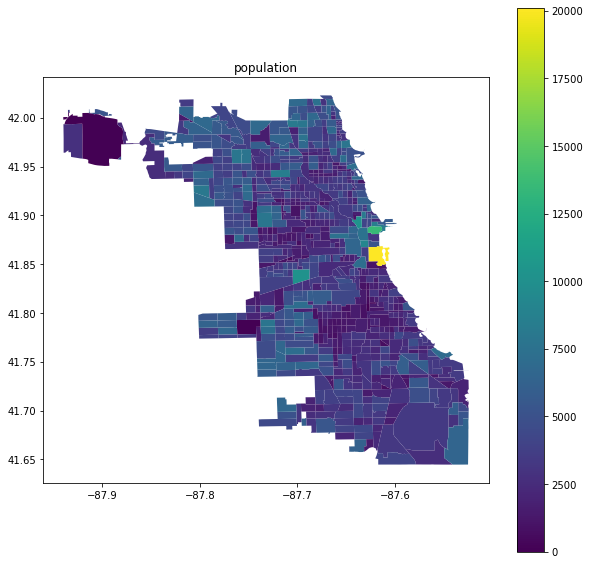

In [11]:
so.simple_map(tract_data,'population','tract')

Nice.

But there's a problem still - we have duplicate tracts??

In [12]:
len(geo.tract)

809

In [13]:
len(set(geo.tract))

808

There's one duplicate. K.

In [14]:
geo.drop_duplicates()

/Users/drewkeller/opt/anaconda3/envs/broadbandequity/lib/python3.8/site-packages/geopandas/array.py:117: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community,geometry
0,37281.254752,6.177154e+07,0.000000,60840000,840000,60,"MULTIPOLYGON (((1096672.940 1927611.312, 10966..."
1,6102.900390,1.777035e+06,0.000000,76840801,840801,76,"MULTIPOLYGON (((1096672.956 1927611.220, 10966..."
2,16035.054991,8.947394e+06,0.320945,59840300,840300,59,"POLYGON ((1163591.927 1881471.238, 1163525.437..."
3,14719.012184,8.946045e+06,0.320896,60840200,840200,60,"POLYGON ((1172724.229 1887341.263, 1172726.397..."
4,15186.400644,1.230614e+07,0.441424,34841100,841100,34,"POLYGON ((1176041.550 1889791.988, 1176043.375..."
...,...,...,...,...,...,...,...
804,13232.831455,1.060785e+07,0.380506,63630300,630300,63,"POLYGON ((1155907.427 1870638.274, 1155911.403..."
805,10648.157958,7.085428e+06,0.254156,63630400,630400,63,"POLYGON ((1158644.638 1868060.212, 1158578.114..."
806,10637.040410,7.079999e+06,0.253961,63630500,630500,63,"POLYGON ((1161234.867 1870796.334, 1161237.841..."
807,10625.328587,7.059211e+06,0.253215,63630800,630800,63,"POLYGON ((1158719.744 1865406.385, 1158653.489..."


... but not an identical duplicate. Weird.

In [15]:
wheres_that_pesky_duplicate = geo.groupby(by='tract').count().reset_index()
wheres_that_pesky_duplicate

,tract,Shape_Leng,Shape_Area,SqMiles,GEOID2,community,geometry
0,010100,1,1,1,1,1,1
1,010201,1,1,1,1,1,1
2,010202,1,1,1,1,1,1
3,010300,1,1,1,1,1,1
4,010400,1,1,1,1,1,1
...,...,...,...,...,...,...,...
803,843700,1,1,1,1,1,1
804,843800,1,1,1,1,1,1
805,843900,1,1,1,1,1,1
806,980000,1,1,1,1,1,1


In [16]:
wheres_that_pesky_duplicate.geometry.argmax()

769

In [17]:
wheres_that_pesky_duplicate.iloc[769]

tract         840000
Shape_Leng         2
Shape_Area         2
SqMiles            2
GEOID2             2
community          2
geometry           2
Name: 769, dtype: object

In [18]:
geo_sorted = geo.sort_values(by='tract').reset_index()
geo_sorted

,index,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community,geometry
0,284,9344.924409,3.947738e+06,0.141606,01010100,010100,01,"MULTIPOLYGON (((1163650.796 1950346.071, 11635..."
1,53,9303.405025,5.430137e+06,0.194780,01010201,010201,01,"POLYGON ((1162635.351 1950347.518, 1162653.589..."
2,563,8288.382640,3.785758e+06,0.135796,01010202,010202,01,"POLYGON ((1163585.702 1950341.343, 1163650.796..."
3,285,9999.174511,5.057142e+06,0.181401,01010300,010300,01,"POLYGON ((1166164.726 1950331.296, 1166164.580..."
4,286,14775.727899,5.855808e+06,0.210049,01010400,010400,01,"POLYGON ((1168721.277 1942712.343, 1168634.963..."
...,...,...,...,...,...,...,...,...
804,127,19607.614814,1.359578e+07,0.487684,05843700,843700,05,"POLYGON ((1159736.259 1923838.988, 1159739.975..."
805,79,15935.894972,1.409588e+07,0.505622,61843800,843800,61,"POLYGON ((1174577.285 1868470.951, 1174565.835..."
806,159,26723.238309,1.657846e+07,0.594673,42843900,843900,42,"POLYGON ((1192022.501 1863616.394, 1191995.200..."
807,638,78301.198349,2.016751e+08,7.234127,76980000,980000,76,"MULTIPOLYGON (((1091162.814 1942146.116, 10911..."


In [19]:
geo_sorted[769:771]

,index,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community,geometry
769,0,37281.254752,6.177154e+07,0.000000,60840000,840000,60,"MULTIPOLYGON (((1096672.940 1927611.312, 10966..."
770,201,15230.370980,6.368404e+06,0.228436,60840000,840000,60,"POLYGON ((1174234.851 1884392.196, 1174242.521..."


Hm. Based on Shape_Area and Shape_Leng, those are not really interchangeable. We don't like that. We're gonna have to map them and see which one is legit.

In [20]:
duplicates = geo_sorted[geo_sorted.tract=='840000']
duplicates

,index,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community,geometry
769,0,37281.254752,6.177154e+07,0.000000,60840000,840000,60,"MULTIPOLYGON (((1096672.940 1927611.312, 10966..."
770,201,15230.370980,6.368404e+06,0.228436,60840000,840000,60,"POLYGON ((1174234.851 1884392.196, 1174242.521..."


In [21]:
big_dup = duplicates[round(duplicates.Shape_Leng)==37281]
small_dup = duplicates[round(duplicates.Shape_Leng)==15230]

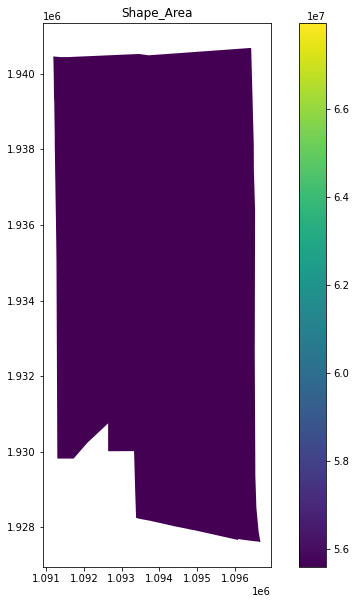

In [22]:
so.simple_map(big_dup,'Shape_Area','tract')

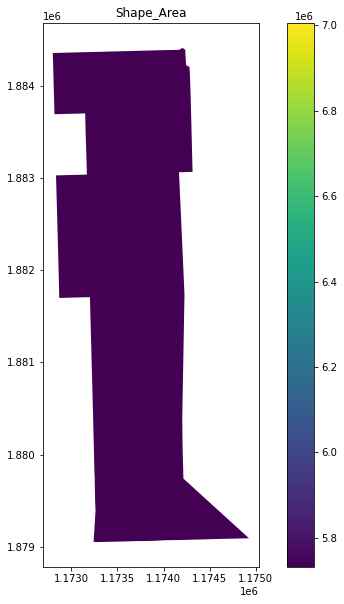

In [23]:
so.simple_map(small_dup,'Shape_Area','tract')

Where are these guys?

/Users/drewkeller/opt/anaconda3/envs/broadbandequity/lib/python3.8/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/drewkeller/opt/anaconda3/envs/broadbandequity/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/drewkeller/opt/anaconda3/envs/broadbandequity/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

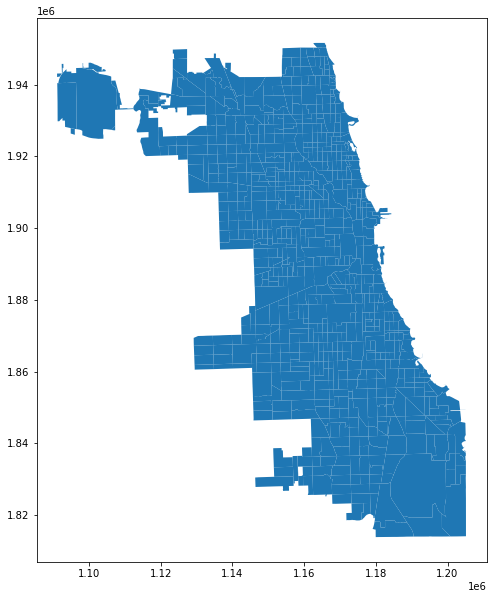

In [24]:
geo.plot()

"small_dup" is the right one; it's the in Bridgeport / Armour Square area. "big_dup" is the left tract in O'Hare and is resident-less.

In [39]:
# check we can filter "big_dup"
geo[(geo["tract"]=='840000') & (round(geo["SqMiles"],2)==0.23)]


,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community,geometry
201,15230.37098,6.368404e+06,0.228436,60840000,840000,60,"POLYGON ((1174234.851 1884392.196, 1174242.521..."


In [40]:
# delete "big_dup"
geo = geo[(geo["tract"]!='840000') | (round(geo["SqMiles"],2)!=0.23)]
geo

,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,community,geometry
0,37281.254752,6.177154e+07,0.000000,60840000,840000,60,"MULTIPOLYGON (((1096672.940 1927611.312, 10966..."
1,6102.900390,1.777035e+06,0.000000,76840801,840801,76,"MULTIPOLYGON (((1096672.956 1927611.220, 10966..."
2,16035.054991,8.947394e+06,0.320945,59840300,840300,59,"POLYGON ((1163591.927 1881471.238, 1163525.437..."
3,14719.012184,8.946045e+06,0.320896,60840200,840200,60,"POLYGON ((1172724.229 1887341.263, 1172726.397..."
4,15186.400644,1.230614e+07,0.441424,34841100,841100,34,"POLYGON ((1176041.550 1889791.988, 1176043.375..."
...,...,...,...,...,...,...,...
804,13232.831455,1.060785e+07,0.380506,63630300,630300,63,"POLYGON ((1155907.427 1870638.274, 1155911.403..."
805,10648.157958,7.085428e+06,0.254156,63630400,630400,63,"POLYGON ((1158644.638 1868060.212, 1158578.114..."
806,10637.040410,7.079999e+06,0.253961,63630500,630500,63,"POLYGON ((1161234.867 1870796.334, 1161237.841..."
807,10625.328587,7.059211e+06,0.253215,63630800,630800,63,"POLYGON ((1158719.744 1865406.385, 1158653.489..."


In [41]:
# check there are now no duplicates
len(geo.tract) == len(set(geo.tract))

True

In [42]:
# write
geo.to_file(tract_shapefile)